Mean ± Std over 100 stratified splits (test size = 25%)


,Model,Accuracy (mean),Accuracy (std),Balanced Acc (mean),Balanced Acc (std)
4,Random Forest,0.979636,0.005167,0.979236,0.006003
3,Decision Tree,0.965938,0.006963,0.963101,0.007933
2,KNN (k=5),0.959650,0.006337,0.957523,0.007153
1,SVM (RBF),0.937269,0.007224,0.932494,0.008176
0,Logistic Regression,0.872017,0.010664,0.867396,0.011627


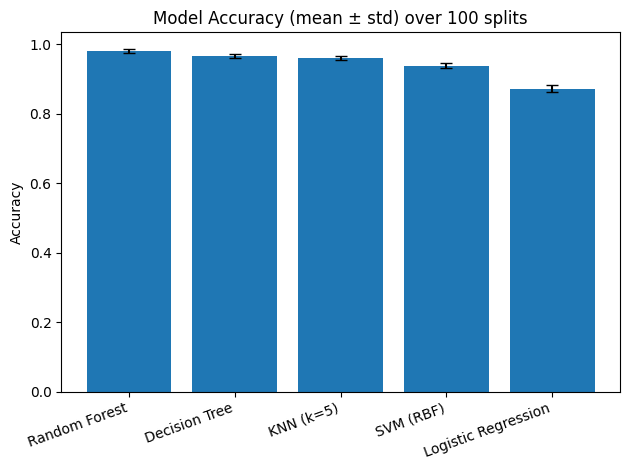

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# --- Load dataset ---
DATA_PATH = "ic50.tsv"
df = pd.read_csv(DATA_PATH, sep="\t", low_memory=False)

# --- Preprocessing (same as your notebook) ---
df["Standard Value"] = pd.to_numeric(df.get("Standard Value"), errors="coerce")
df = df.dropna(subset=["Standard Value"])
df["Binder"] = (df["Standard Value"] <= 2000).astype(int)

features = [
    "Molecular Weight", "AlogP", "#RO5 Violations",
    "Ligand Efficiency BEI", "Ligand Efficiency LE",
    "Ligand Efficiency LLE", "Ligand Efficiency SEI"
]
for col in features:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

X = df[features].fillna(df[features].mean())
y = df["Binder"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Define models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, class_weight="balanced"),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=0, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(
        n_estimators=300, random_state=0, n_jobs=-1, class_weight="balanced"
    ),
}

# --- Evaluate over 100 random splits ---
N_RUNS = 100
TEST_SIZE = 0.25
results = {name: {"acc": [], "bal_acc": []} for name in models}

for seed in range(N_RUNS):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_scaled, y, test_size=TEST_SIZE, stratify=y, random_state=seed
    )
    for name, model in models.items():
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        results[name]["acc"].append(accuracy_score(y_te, y_pred))
        results[name]["bal_acc"].append(balanced_accuracy_score(y_te, y_pred))

# --- Aggregate results ---
summary = pd.DataFrame([
    {
        "Model": name,
        "Accuracy (mean)": np.mean(m["acc"]),
        "Accuracy (std)": np.std(m["acc"]),
        "Balanced Acc (mean)": np.mean(m["bal_acc"]),
        "Balanced Acc (std)": np.std(m["bal_acc"]),
    }
    for name, m in results.items()
]).sort_values(by="Accuracy (mean)", ascending=False)

print("Mean ± Std over 100 stratified splits (test size = 25%)")
display(summary)

# --- Plot ---
plt.figure()
plt.bar(summary["Model"], summary["Accuracy (mean)"], yerr=summary["Accuracy (std)"], capsize=4)
plt.xticks(rotation=20, ha="right")
plt.ylabel("Accuracy")
plt.title("Model Accuracy (mean ± std) over 100 splits")
plt.tight_layout()
plt.show()
